In [112]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import spearmanr, kruskal

In [79]:
df = pd.read_csv('../data/clean_dataset.csv', index_col=0)

df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


## Feature presentation

1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines. 

2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature. 

3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities. 

4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.

5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities. 

6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time. 

7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities. 

8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy. 

9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours. 

10) Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date. 

11) Price: Target variable stores information of the ticket price.

In [80]:
df.shape

(300153, 11)

In [81]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  str    
 1   flight            300153 non-null  str    
 2   source_city       300153 non-null  str    
 3   departure_time    300153 non-null  str    
 4   stops             300153 non-null  str    
 5   arrival_time      300153 non-null  str    
 6   destination_city  300153 non-null  str    
 7   class             300153 non-null  str    
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), str(8)
memory usage: 25.2 MB


In [82]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [83]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [84]:
#sns.pairplot(df)

### analysing column : airline ###


airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

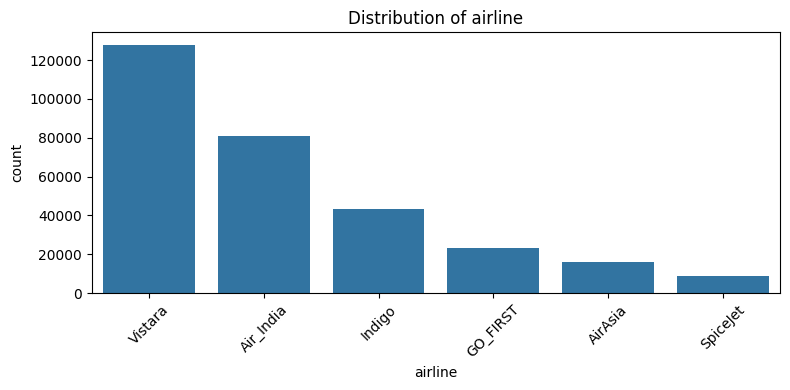

### analysing column : flight ###


flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
6E-6474       1
G8-405        1
6E-543        1
SG-1058       1
6E-3211       1
Name: count, Length: 1561, dtype: int64

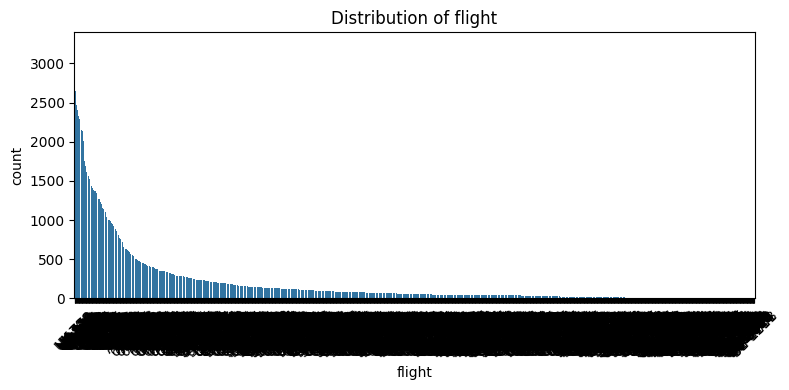

### analysing column : source_city ###


source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

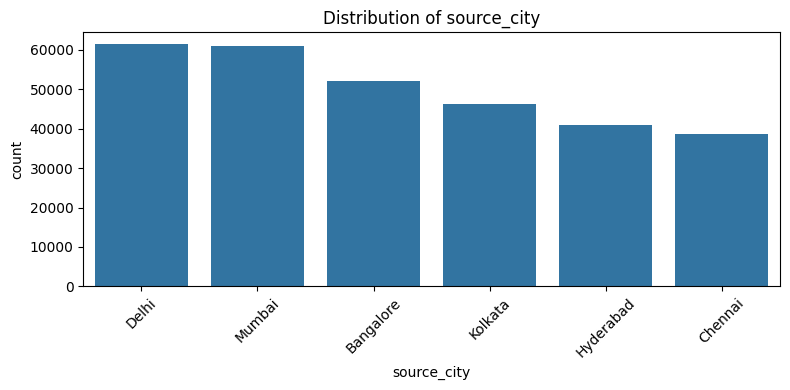

### analysing column : departure_time ###


departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

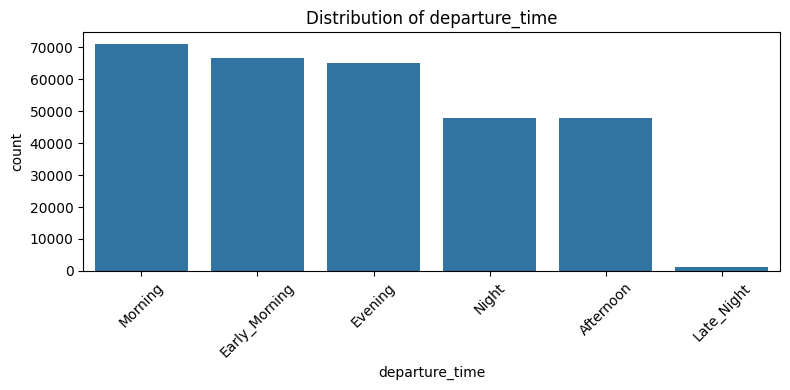

### analysing column : stops ###


stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

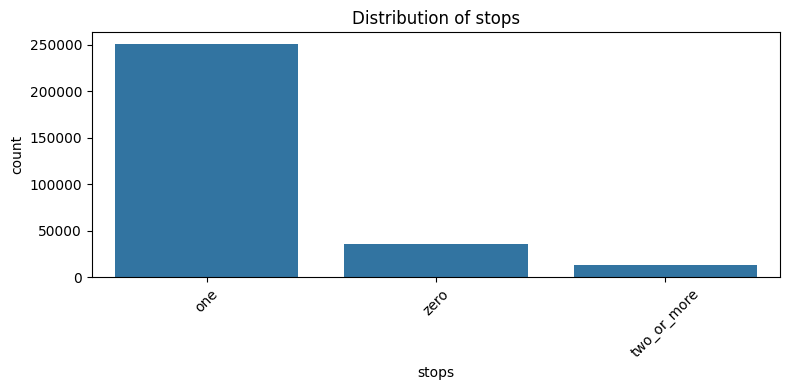

### analysing column : arrival_time ###


arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: count, dtype: int64

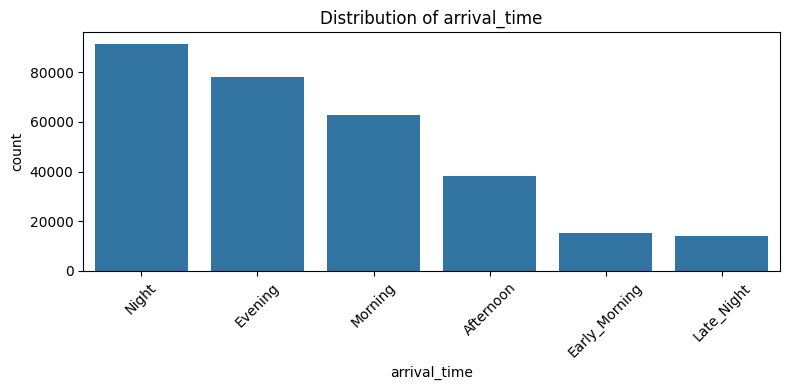

### analysing column : destination_city ###


destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64

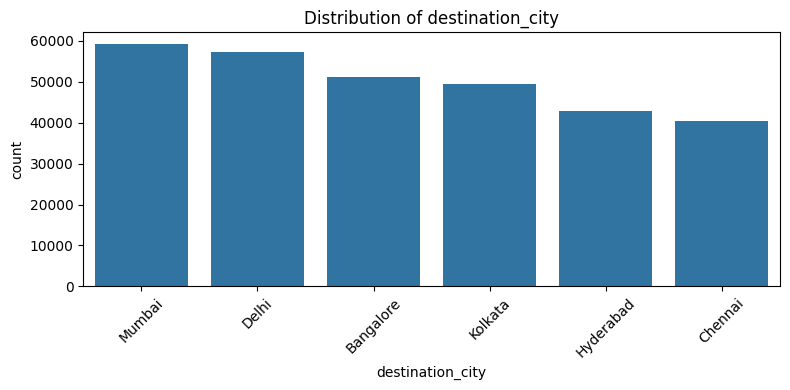

### analysing column : class ###


class
Economy     206666
Business     93487
Name: count, dtype: int64

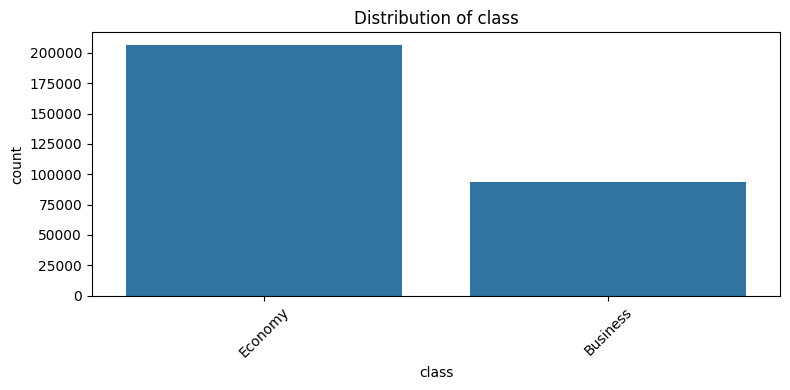

In [85]:
continuous_col = ['duration', 'days_left', 'price']
discrete_col   = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

def univariate_discrete_analysis(df, discrete_col):
    for col in discrete_col:
        print(f'### analysing column : {col} ###')
        count = df[col].value_counts()
        display(count)

        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=col, order=count.index)

        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def univariate_continuous_analysis(df, continuous_col):
    for col in continuous_col:
        print(f'### analysing column : {col} ###')
        stats = df[col].describe()
        variance = df[col].var()

        display(stats)
        print(f'Variance: {variance:.2f}')

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        #histogram
        sns.histplot(df[col], kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')
        
        #boxplot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()


    
univariate_discrete_analysis(df=df, discrete_col=discrete_col)


### analysing column : duration ###


count    300153.000000
mean         12.221021
std           7.191997
min           0.830000
25%           6.830000
50%          11.250000
75%          16.170000
max          49.830000
Name: duration, dtype: float64

Variance: 51.72


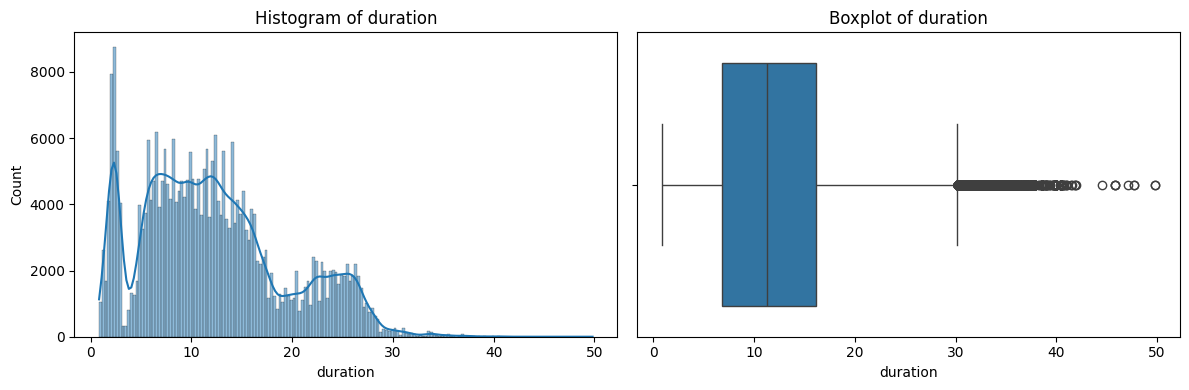

### analysing column : days_left ###


count    300153.000000
mean         26.004751
std          13.561004
min           1.000000
25%          15.000000
50%          26.000000
75%          38.000000
max          49.000000
Name: days_left, dtype: float64

Variance: 183.90


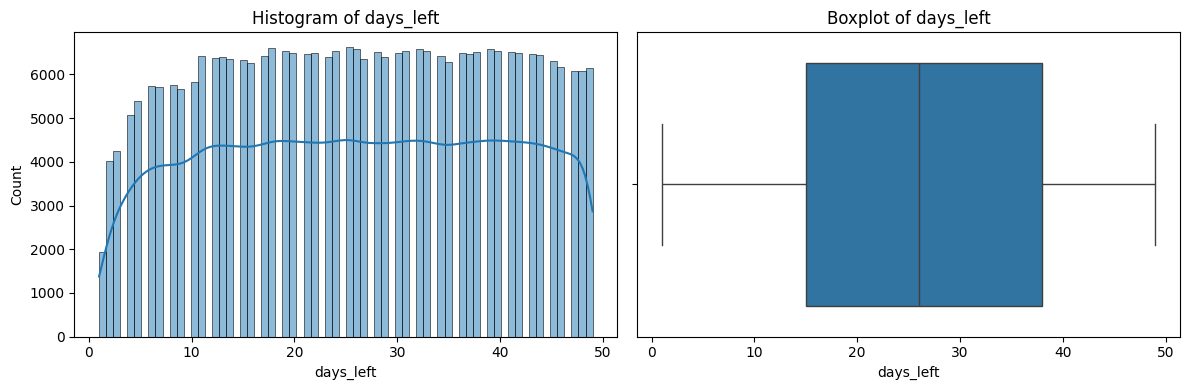

### analysing column : price ###


count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

Variance: 515188643.40


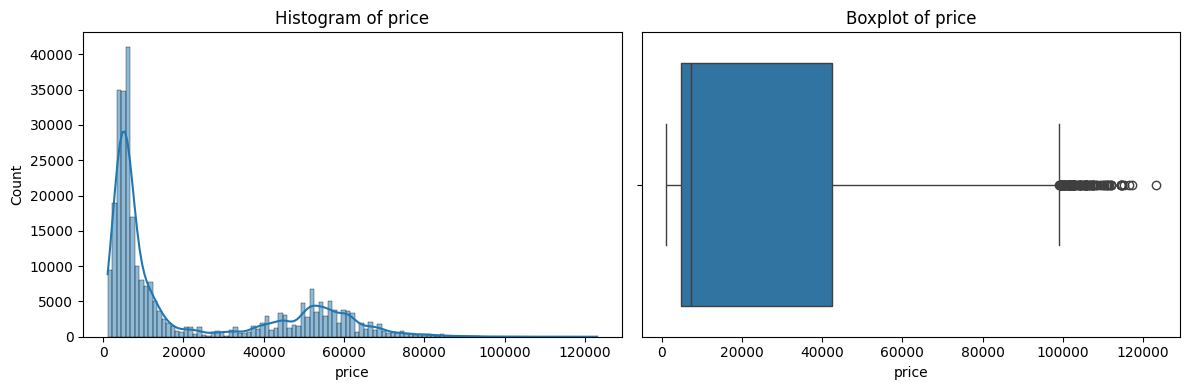

In [86]:
univariate_continuous_analysis(df=df, continuous_col=continuous_col)

### Multivariate analysis

Need to do 3 levels of multivariate analysis :
- continuous  ↔ continuous
- discrete    ↔ continuous
- discrete    ↔ discrete


for continuous columns, need to check both Pearson (linear relations) & Spearman (monotone relations) 

Pearson correlations


,duration,days_left,price
duration,1.000000,-0.039157,0.204222
days_left,-0.039157,1.000000,-0.091949
price,0.204222,-0.091949,1.000000


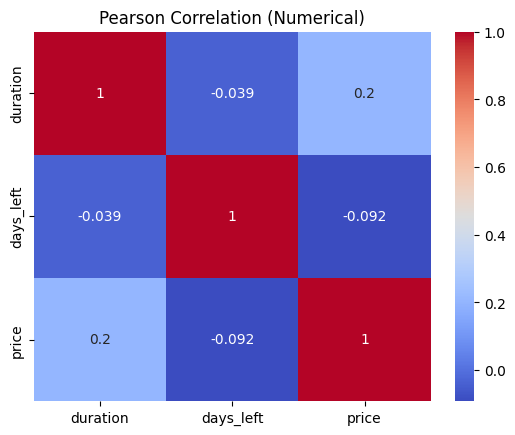

Spearman correlations


,duration,days_left,price
duration,1.000000,-0.033094,0.318841
days_left,-0.033094,1.000000,-0.267019
price,0.318841,-0.267019,1.000000


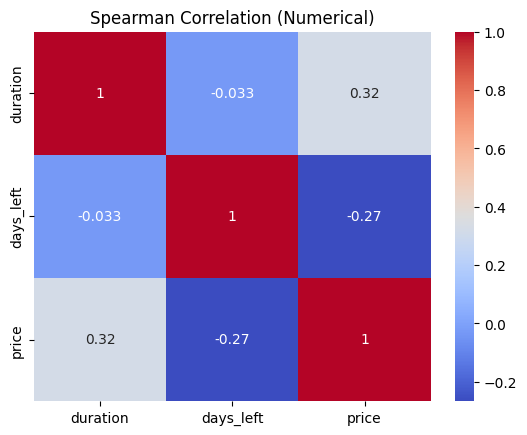

In [87]:
corr_pearson  = df[continuous_col].corr(method='pearson')
corr_spearman = df[continuous_col].corr(method='spearman')

print('Pearson correlations')
display(corr_pearson)
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation (Numerical)')
plt.show()

print('Spearman correlations')
display(corr_spearman)

sns.heatmap(corr_spearman, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation (Numerical)')
plt.show()


Let's check the relation between each variable and the final flight price

##### 1. Duration VS. Price

Question : Are longer flight (in duration) associated to more expensive price  ?

Testing linear correlation between :

duration (continuous variable)
price (continuous variable)

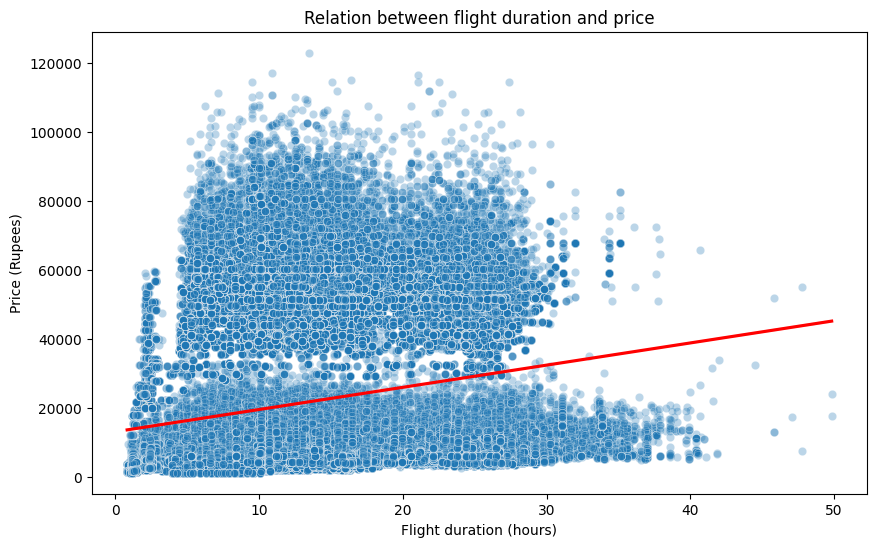

In [88]:
#relation between flight duration & price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="duration", y="price", alpha=0.3)
sns.regplot(
    data=df,
    x="duration",
    y="price",
    scatter=False,
    color="red"
)
plt.title("Relation between flight duration and price")
plt.xlabel("Flight duration (hours)")
plt.ylabel("Price (Rupees)")
plt.show()


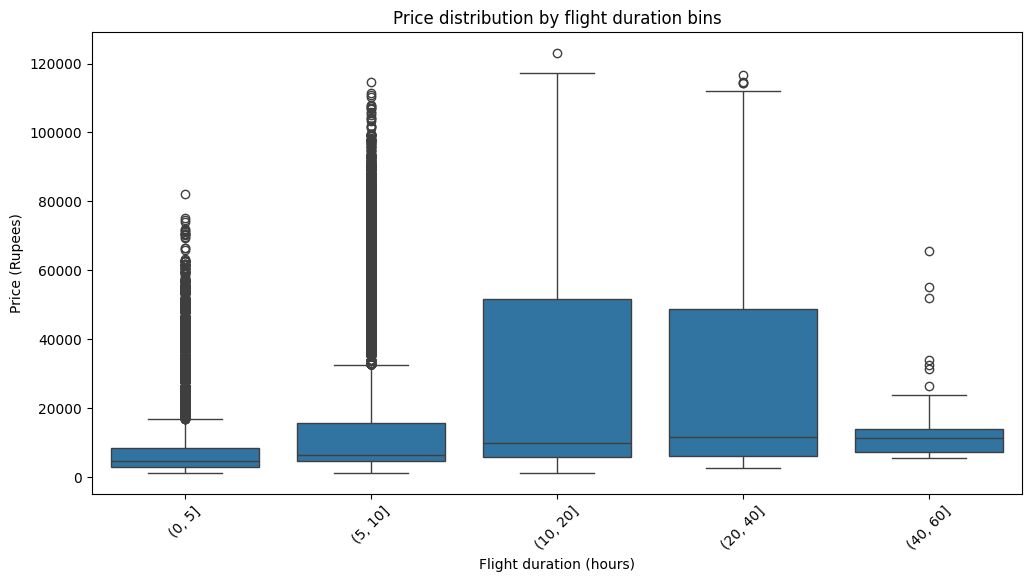

In [89]:
df["duration_bin"] = pd.cut(
    df["duration"],
    bins=[0, 5, 10, 20, 40, 60]
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="duration_bin",
    y="price"
)
plt.title("Price distribution by flight duration bins")
plt.xlabel("Flight duration (hours)")
plt.ylabel("Price (Rupees)")
plt.xticks(rotation=45)
plt.show()


<b>Hypothesis</b> : 

HO : the linear correlation between duration & price is null.

H1 : the linear correlation between duration & price is significative and not null.

In [90]:
#Statistical correlation test between duration & price
corr_duration_price, p_value_duration_price = spearmanr(df["duration"], df["price"])

alpha = 0.02

print("Correaltion (duration, price) :", corr_duration_price)
print("p-value :", p_value_duration_price)

if p_value_duration_price < alpha:
    print(f"p-value < {alpha} : we can reject H0.")
    print("Conclusion : There is a significative linear correlation between the flight duration and the flight price.")
else:
    print(f"p-value ≥ {alpha} : we cannot reject H0.")
    print("Conclusion : There is no clear significative linear correlation between the flight duration and the flight price.")

Correaltion (duration, price) : 0.3188412266334599
p-value : 0.0
p-value < 0.02 : we can reject H0.
Conclusion : There is a significative linear correlation between the flight duration and the flight price.


#### 2. Air supplier VS. Price

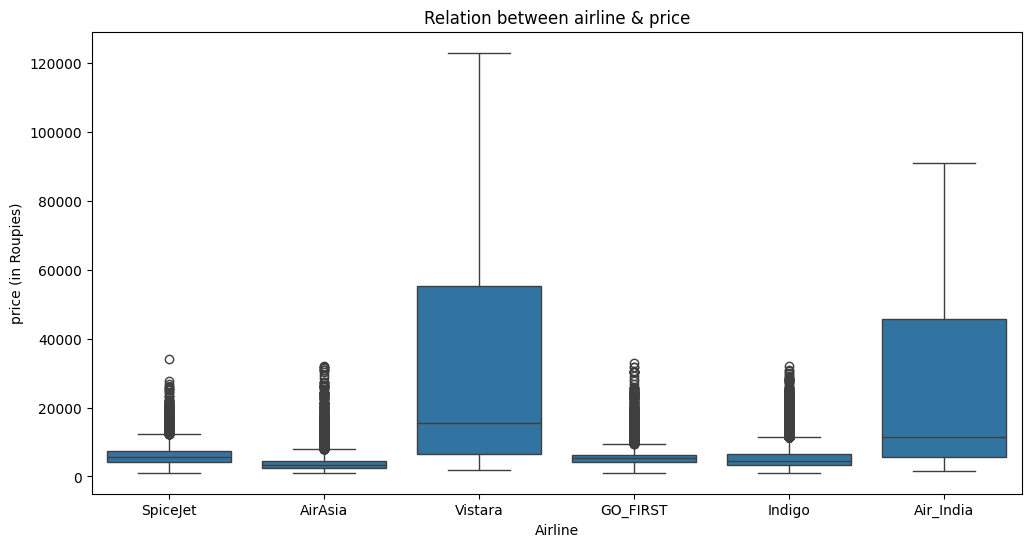

In [91]:
#relation between air supplier and price
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='airline', y='price')
plt.title('Relation between airline & price')
plt.xlabel('Airline')
plt.ylabel('price (in Roupies)')
plt.show()

#### 3. Amount of stops VS. Price

Does the flight price fluctuate depending the amount of stops ?

In [92]:
#let's check basic distribution of stops
df.groupby("stops")["price"].agg(["median", "mean", "count", "std"])


,median,mean,count,std
stops,,,,
one,7959.0,22900.992482,250863,23626.066584
two_or_more,8307.0,14113.450775,13286,17664.332033
zero,4499.0,9375.938535,36004,10623.008293


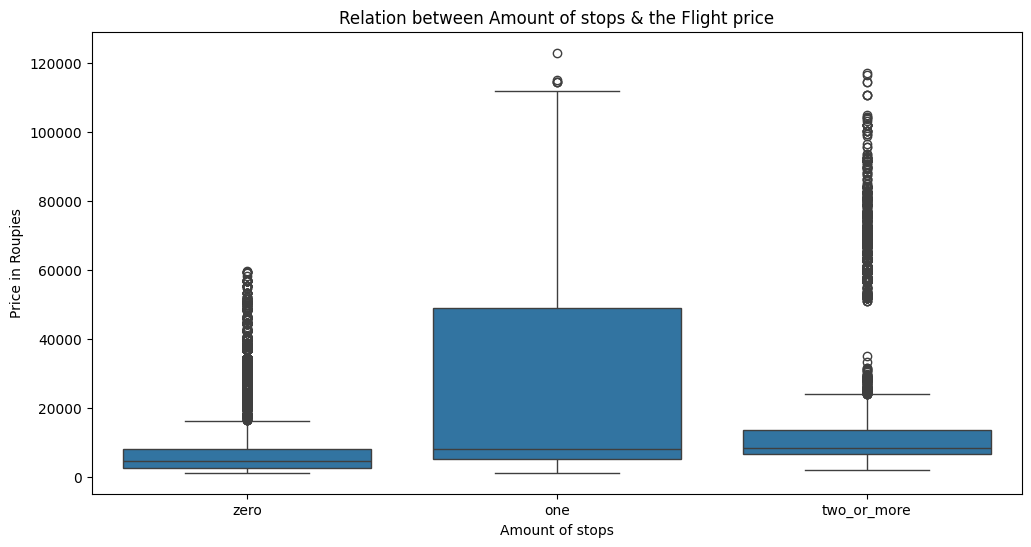

In [93]:
#relation between amount of stops & price
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='stops', y='price')
plt.title('Relation between Amount of stops & the Flight price')
plt.xlabel('Amount of stops')
plt.ylabel('Price in Roupies')
plt.show()

<b>Hypothesis</b> : 

HO - no correlation between stops & price - the average price is the same regardless of the amount of stops

H1 - the average price does vary depending on the amount of stops

In [94]:
stops_unique = sorted(df['stops'].unique())
print('amount of stops : ', stops_unique)

groups_price_by_stops = [df[df['stops'] ==stop]['price'].values for stop in stops_unique]

print(groups_price_by_stops)

#stat test
#ANOVA not relevant because unenven group sizes & uneven variance. 
#Price is very right-skewed 

#Kruskal–Wallis does test between groups without need to normalise
h_stat_stop, p_value_stop = kruskal(*groups_price_by_stops)

print('H stat (stop VS. price) :', h_stat_stop)
print('p-value stop) :', p_value_stop)

if p_value_stop < alpha:
    print(f"p-value < {alpha} : we can reject H0.")
    print("Conclusion : There is a significative correlation between the amount of stops and the flight price. Flight price does vary depending on the amount of stops")
else:
    print(f"p-value ≥ {alpha} : we cannot reject H0.")
    print("Conclusion : There is no clear significative correlation between the amount of stops and the flight price.")


amount of stops :  ['one', 'two_or_more', 'zero']
[array([ 5949,  5949,  5954, ..., 79099, 81585, 81585], shape=(250863,)), array([11678, 12045, 11295, ..., 71169, 77329, 68739], shape=(13286,)), array([ 5953,  5953,  5956, ..., 15000, 15000, 15000], shape=(36004,))]
H stat (stop VS. price) : 20484.29943114362
p-value stop) : 0.0
p-value < 0.02 : we can reject H0.
Conclusion : There is a significative correlation between the amount of stops and the flight price. Flight price does vary depending on the amount of stops


In [95]:
#stop is an ordinal discrete variable
# #let's add to the previous statistical test another check : is there a monotonous correlation between stops & price ?
df['stop_num'] = df['stops'].map({'zero': 0, 'one': 1, 'two_or_more':2}) 

spearman_corr, p_value_spearman_stop = spearmanr(df['stop_num'], df['price'])

print(f"Spearman corr: {spearman_corr:.3f}")
print(f"p_value_spearman_stop: {p_value_spearman_stop:.5e}")

Spearman corr: 0.223
p_value_spearman_stop: 0.00000e+00


Medians do decrease between 0 and 2 stops - there is a significative negative monotonous relation validated by Spearman test.
Stops variable does have a significative impact on the price.

#### 4. Amount of Booking Lead time in days before the flight

Does booking in advance lead to cheaper flight price ?

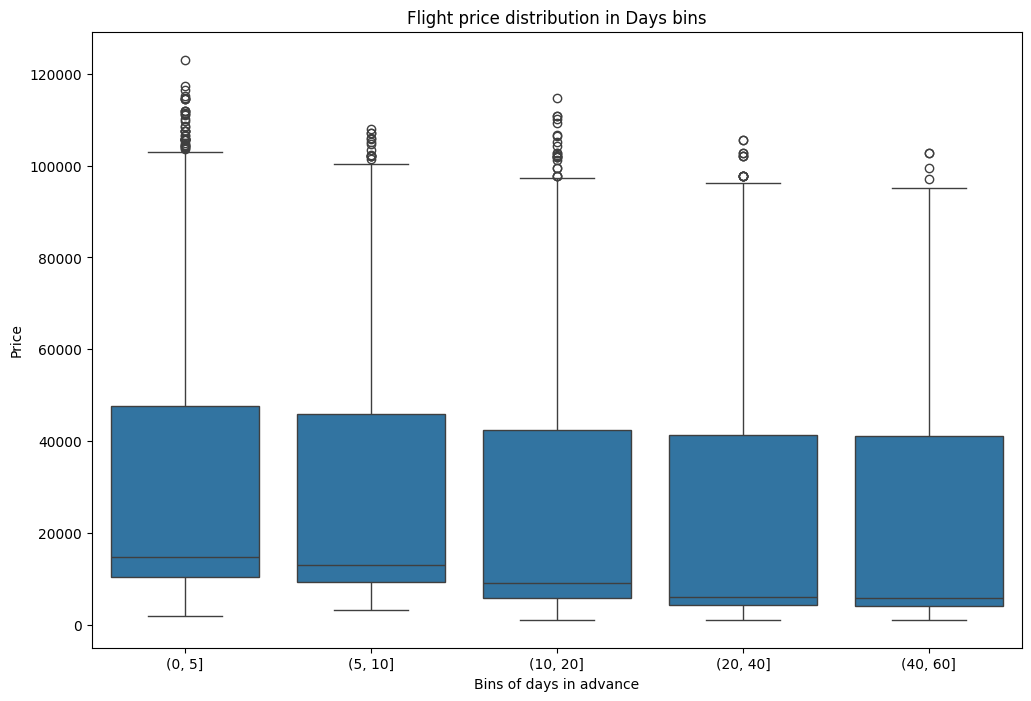

In [96]:
df['days_left'].unique()

df['days_bin'] = pd.cut(df['days_left'], bins = [0, 5, 10, 20, 40, 60])

plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='days_bin', y='price')
plt.title('Flight price distribution in Days bins')
plt.xlabel('Bins of days in advance')
plt.ylabel('Price')

plt.show()

In [97]:
df.groupby("days_bin")["price"].agg(["median", "mean", "count", "std"])

,median,mean,count,std
days_bin,,,,
"(0, 5]",14744.0,27132.161103,20670,23724.297912
"(5, 10]",13089.0,25326.878559,28697,22087.878316
"(10, 20]",9201.0,21260.475515,64223,22054.757136
"(20, 40]",6112.0,19509.728511,129858,22683.070001
"(40, 60]",5939.0,19108.742210,56705,22670.225554


The average and median price do seem to significatively decrease the higher the amount of days in advance

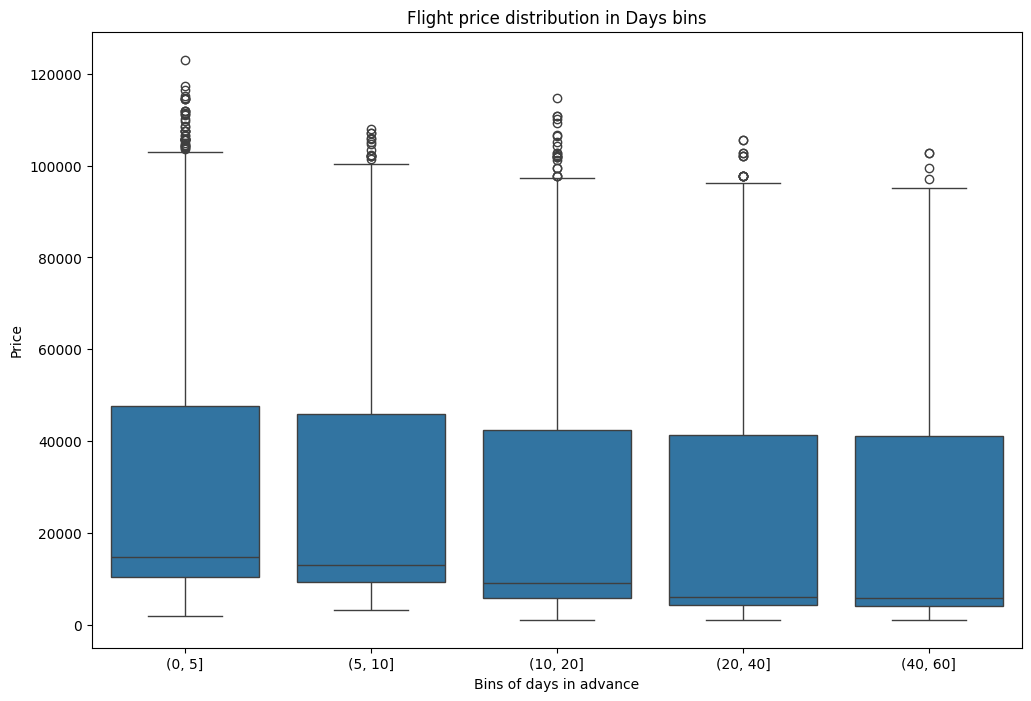

In [98]:
df['days_left'].unique()

df['days_bin'] = pd.cut(df['days_left'], bins = [0, 5, 10, 20, 40, 60])

plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='days_bin', y='price')
plt.title('Flight price distribution in Days bins')
plt.xlabel('Bins of days in advance')
plt.ylabel('Price')

plt.show()

<b>Hypothesis</b> : 

HO : There is no significative correlation between the amount of booking lead time in days and the flight price

H1 : There is a significative linear correlation between the amount of booking lead time in days and the flight price

In [99]:
corr_days_price, p_value_days_price = spearmanr(df['days_left'], df['price'])

print(f"Spearman correlation (days_left, price):{corr_days_price:.3f}")
print(f"p-value booking days in advance: {p_value_days_price:.5e}")

if p_value_days_price < alpha:
    print(f"p-value < {alpha} : we can reject H0.")
    print("Conclusion : There is a significative correlation between the amount of booking lead time in days and the flight price. Flight price does vary depending on the amount of booked days in advance")
else:
    print(f"p-value ≥ {alpha} : we cannot reject H0.")
    print("Conclusion : There is no clear significative correlation between the amount of booking lead time in days and the flight price.")


Spearman correlation (days_left, price):-0.267
p-value booking days in advance: 0.00000e+00
p-value < 0.02 : we can reject H0.
Conclusion : There is a significative correlation between the amount of booking lead time in days and the flight price. Flight price does vary depending on the amount of booked days in advance


### Preprocessing

In [100]:
print('NaN per columns')
df.isna().sum()

NaN per columns


airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
duration_bin        0
stop_num            0
days_bin            0
dtype: int64

In [101]:
#mapping classes
print(df['class'].unique())

df['class_num'] = df['class'].map({'Economy': 0, 'Business': 1})

print(df['class_num'].unique())

<StringArray>
['Economy', 'Business']
Length: 2, dtype: str
[0 1]


In [102]:
print(df['flight'].unique())

print('-' * 30)
print('high cardinality and not informative')
print('-' * 30)

print(df["flight"].value_counts().describe())

<StringArray>
['SG-8709', 'SG-8157',  'I5-764',  'UK-995',  'UK-963',  'UK-945',  'UK-927',
  'UK-951',  'G8-334',  'G8-336',
 ...
  '6E-804', '6E-7183', 'SG-6017', '6E-7208', '6E-7252', '6E-7141',  '6E-557',
 '6E-7127', '6E-7259',  'AI-433']
Length: 1561, dtype: str
------------------------------
high cardinality and not informative
------------------------------
count    1561.000000
mean      192.282511
std       383.622740
min         1.000000
25%        20.000000
50%        55.000000
75%       156.000000
max      3235.000000
Name: count, dtype: float64


In [103]:
le = LabelEncoder()
flight_encoded = le.fit_transform(df['flight'])
mi_flight = mutual_info_regression(flight_encoded.reshape(-1, 1),
                                    df['price'],
                                    random_state=42
                                    )

print(('MI(flight-> price): ', mi_flight[0]))

('MI(flight-> price): ', np.float64(3.8390125233779973))


"Flight" column has a very high Mutual Info Regression ; it is due to its very high cardinality, which pollutes results

"Flight" column is a simple flight identifier with no additional info 

In [104]:
df['flight'].value_counts().head(50)

flight
UK-706    3235
UK-772    2741
UK-720    2650
UK-836    2542
UK-822    2468
UK-828    2440
UK-874    2423
UK-832    2404
UK-826    2335
UK-860    2329
UK-876    2307
UK-878    2285
UK-838    2255
UK-830    2204
UK-870    2199
UK-824    2156
UK-774    2145
UK-708    2140
UK-738    2136
UK-852    2016
UK-776    2015
AI-770    1833
UK-858    1795
UK-808    1761
UK-880    1730
UK-810    1695
AI-440    1690
UK-812    1616
AI-559    1604
AI-543    1580
AI-430    1574
UK-816    1563
AI-763    1560
AI-402    1532
AI-840    1525
AI-538    1525
AI-808    1470
UK-778    1442
UK-866    1441
UK-890    1437
UK-834    1436
UK-850    1412
AI-541    1392
UK-854    1382
UK-988    1381
AI-804    1381
AI-660    1377
AI-867    1374
UK-940    1369
AI-888    1353
Name: count, dtype: int64

In [105]:
#comparing MI to other features
features = ["airline", "class", "duration" , "stops", "days_left", "flight"]

X = df[features].apply(lambda col: col.astype("category").cat.codes)
y = df["price"]

mi = mutual_info_regression(X, y, random_state=42)

pd.Series(mi, index=features).sort_values(ascending=False)


flight       3.838555
duration     2.417341
airline      1.103387
class        0.619941
days_left    0.479290
stops        0.392508
dtype: float64